In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import optuna
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, precision_recall_curve, auc)

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")

TRAIN_PATH = "train_c.csv"
TEST_PATH = "test_c.csv"

In [35]:

class MyMetrics:
    @staticmethod
    def accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.mean(y_true == y_pred)

    @staticmethod
    def precision(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0

    @staticmethod
    def recall(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

    @staticmethod
    def f1_score(y_true, y_pred):
        p = MyMetrics.precision(y_true, y_pred)
        r = MyMetrics.recall(y_true, y_pred)
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0.0
    
    @staticmethod
    def auc_roc(y_true, y_probs):
        y_true = np.array(y_true)
        y_probs = np.array(y_probs)
        desc_score_indices = np.argsort(y_probs)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        n_pos = np.sum(y_true == 1)
        n_neg = np.sum(y_true == 0)
        if n_pos == 0 or n_neg == 0: return 0.0
        
        tpr, fpr = [], []
        tp, fp = 0, 0
        for label in y_true_sorted:
            if label == 1: tp += 1
            else: fp += 1
            tpr.append(tp / n_pos)
            fpr.append(fp / n_neg)
        return np.trapz(tpr, fpr)

    @staticmethod
    def auc_pr(y_true, y_probs):
        y_true = np.array(y_true)
        y_probs = np.array(y_probs)
        desc_score_indices = np.argsort(y_probs)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        precisions, recalls = [], []
        tp, fp = 0, 0
        n_pos = np.sum(y_true == 1)
        if n_pos == 0: return 0.0
        
        for label in y_true_sorted:
            if label == 1: tp += 1
            else: fp += 1
            prec = tp / (tp + fp)
            rec = tp / n_pos
            precisions.append(prec)
            recalls.append(rec)
        return np.trapz(precisions, recalls)

In [36]:

class MyBaggingClassifier:
    def __init__(self, n_estimators=10, max_depth=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.models = []
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            idx = rng.choice(n_samples, size=n_samples, replace=True)
            model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=rng.integers(1e5))
            model.fit(X[idx], y[idx])
            self.models.append(model)
        return self

    def predict(self, X):
        X = np.array(X)
        preds = np.array([m.predict(X) for m in self.models])
        final = []
        for j in range(len(X)):
            vals, counts = np.unique(preds[:, j], return_counts=True)
            final.append(vals[np.argmax(counts)])
        return np.array(final)

class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        self.initial_prediction = None
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        p0 = np.clip(np.mean(y), 1e-10, 1 - 1e-10)
        self.initial_prediction = np.log(p0 / (1 - p0))
        logits = np.full(y.shape, self.initial_prediction)
        
        for i in range(self.n_estimators):
            p = self._sigmoid(logits)
            res = y - p
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state + i)
            tree.fit(X, res)
            update = tree.predict(X)
            logits += self.learning_rate * update
            self.models.append(tree)
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        logits = np.full(X.shape[0], self.initial_prediction)
        for tree in self.models:
            logits += self.learning_rate * tree.predict(X)
        probs = self._sigmoid(logits)
        return np.vstack([1 - probs, probs]).T
        
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

In [37]:

def perform_detailed_eda(df_orig, target_col='LoanApproved'):
    
    df = df_orig.copy()
    
    cols_to_drop = ['ID', 'Id']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        min_date = pd.Timestamp("1970-01-01")
        df['AppDays'] = (df['ApplicationDate'] - min_date).dt.days
        df = df.drop(columns=['ApplicationDate'])

    num_cols = df.select_dtypes(include=[np.number]).columns
    feature_num_cols = [c for c in num_cols if c != target_col]
    
    if target_col in df.columns:
        plt.figure(figsize=(6, 4))
        ax = sns.countplot(x=df[target_col], palette='viridis')
        plt.title(f'Распределение {target_col}')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom')
        plt.show()

    print("Матрица корреляций (Heatmap)")
    if len(feature_num_cols) > 0:
        plt.figure(figsize=(12, 10))
        cols_to_plot = list(feature_num_cols)
        if target_col in df.columns:
            cols_to_plot.append(target_col)
            
        corr = df[cols_to_plot].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        
        sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                    annot=True, fmt=".2f", annot_kws={"size": 8})
        plt.title('Матрица корреляций признаков')
        plt.show()

        if target_col in corr.columns:
            target_corr = corr[target_col].drop(target_col).sort_values(ascending=False)
            
            plt.figure(figsize=(10, 6))
            colors = ['#2ca02c' if x > 0 else '#d62728' for x in target_corr.values]
            sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
            plt.axvline(0, color='black', linewidth=1)
            plt.title(f'Корреляция признаков с {target_col}')
            plt.xlabel('Коэффициент корреляции')
            plt.show()
            
            print(f"\n>>> Распределение топ-6 числовых признаков по {target_col}")
            top_corr_features = target_corr.abs().sort_values(ascending=False).index[:6]
            
            n_cols = 3
            n_rows = (len(top_corr_features) + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
            axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
            
            for i, col in enumerate(top_corr_features):
                sns.kdeplot(data=df, x=col, hue=target_col, fill=True, palette='crest', ax=axes[i], alpha=0.5)
                axes[i].set_title(f'Плотность: {col}')
                
            for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
            plt.tight_layout()
            plt.show()

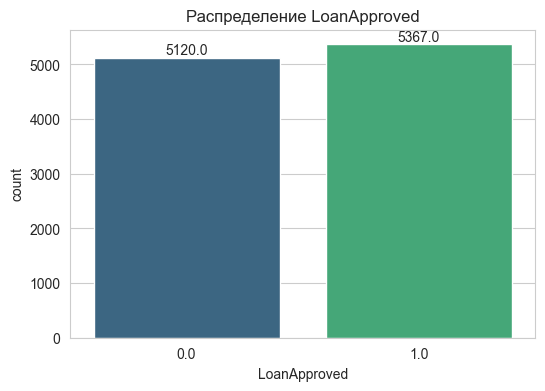

Матрица корреляций (Heatmap)


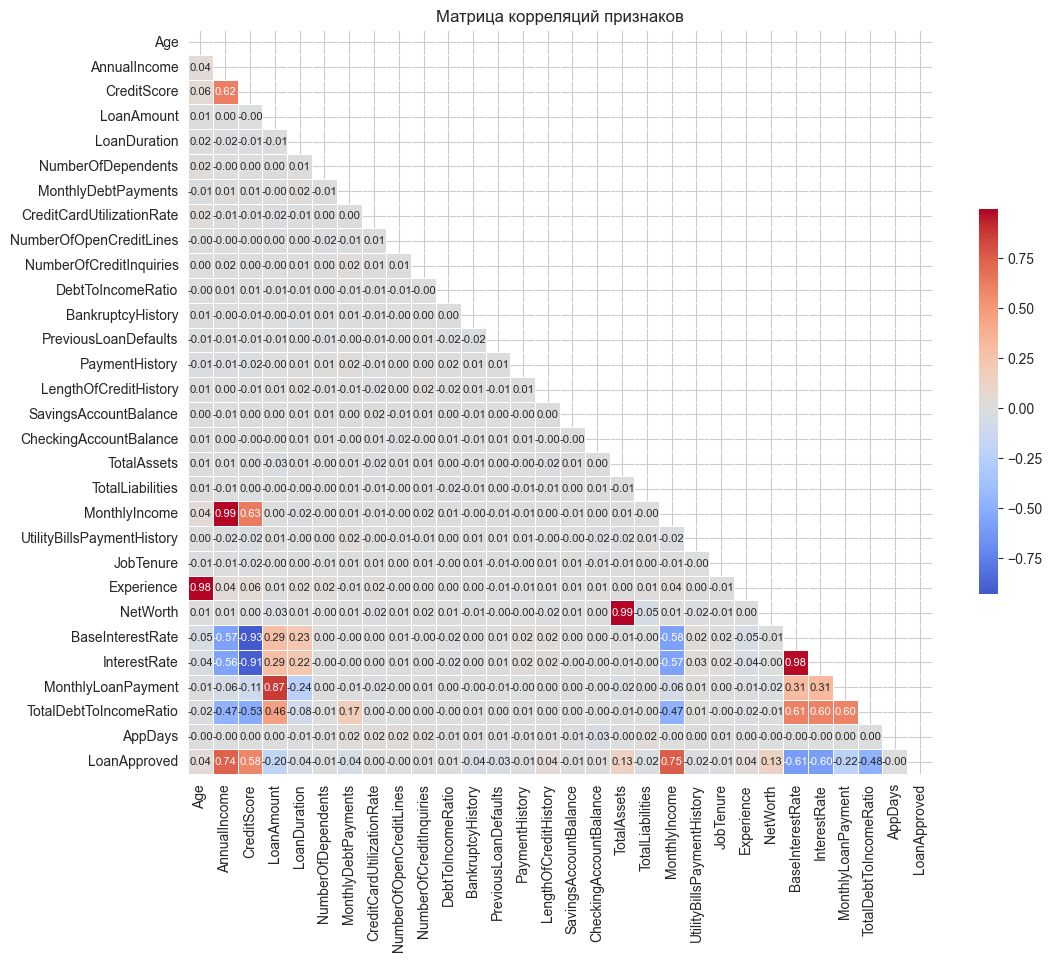

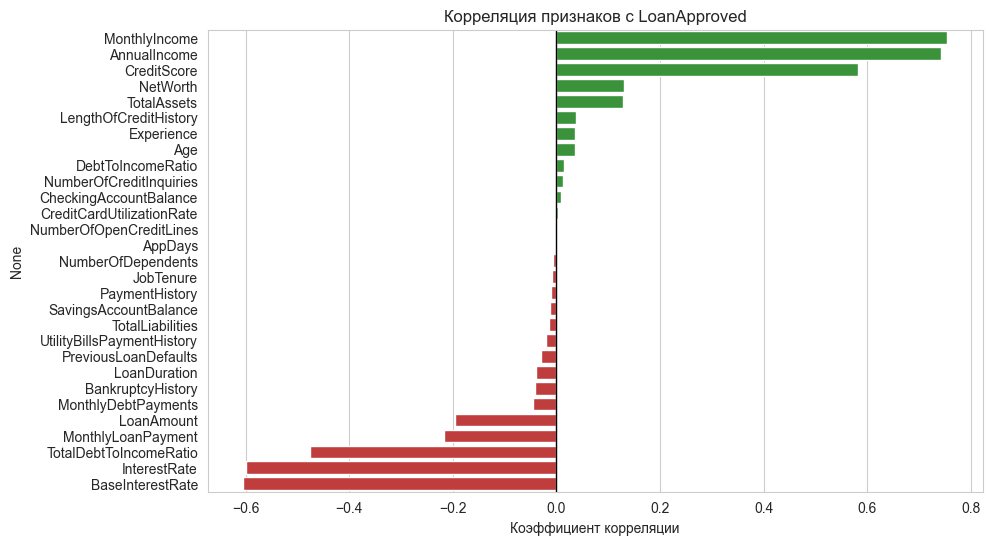


>>> Распределение топ-6 числовых признаков по LoanApproved


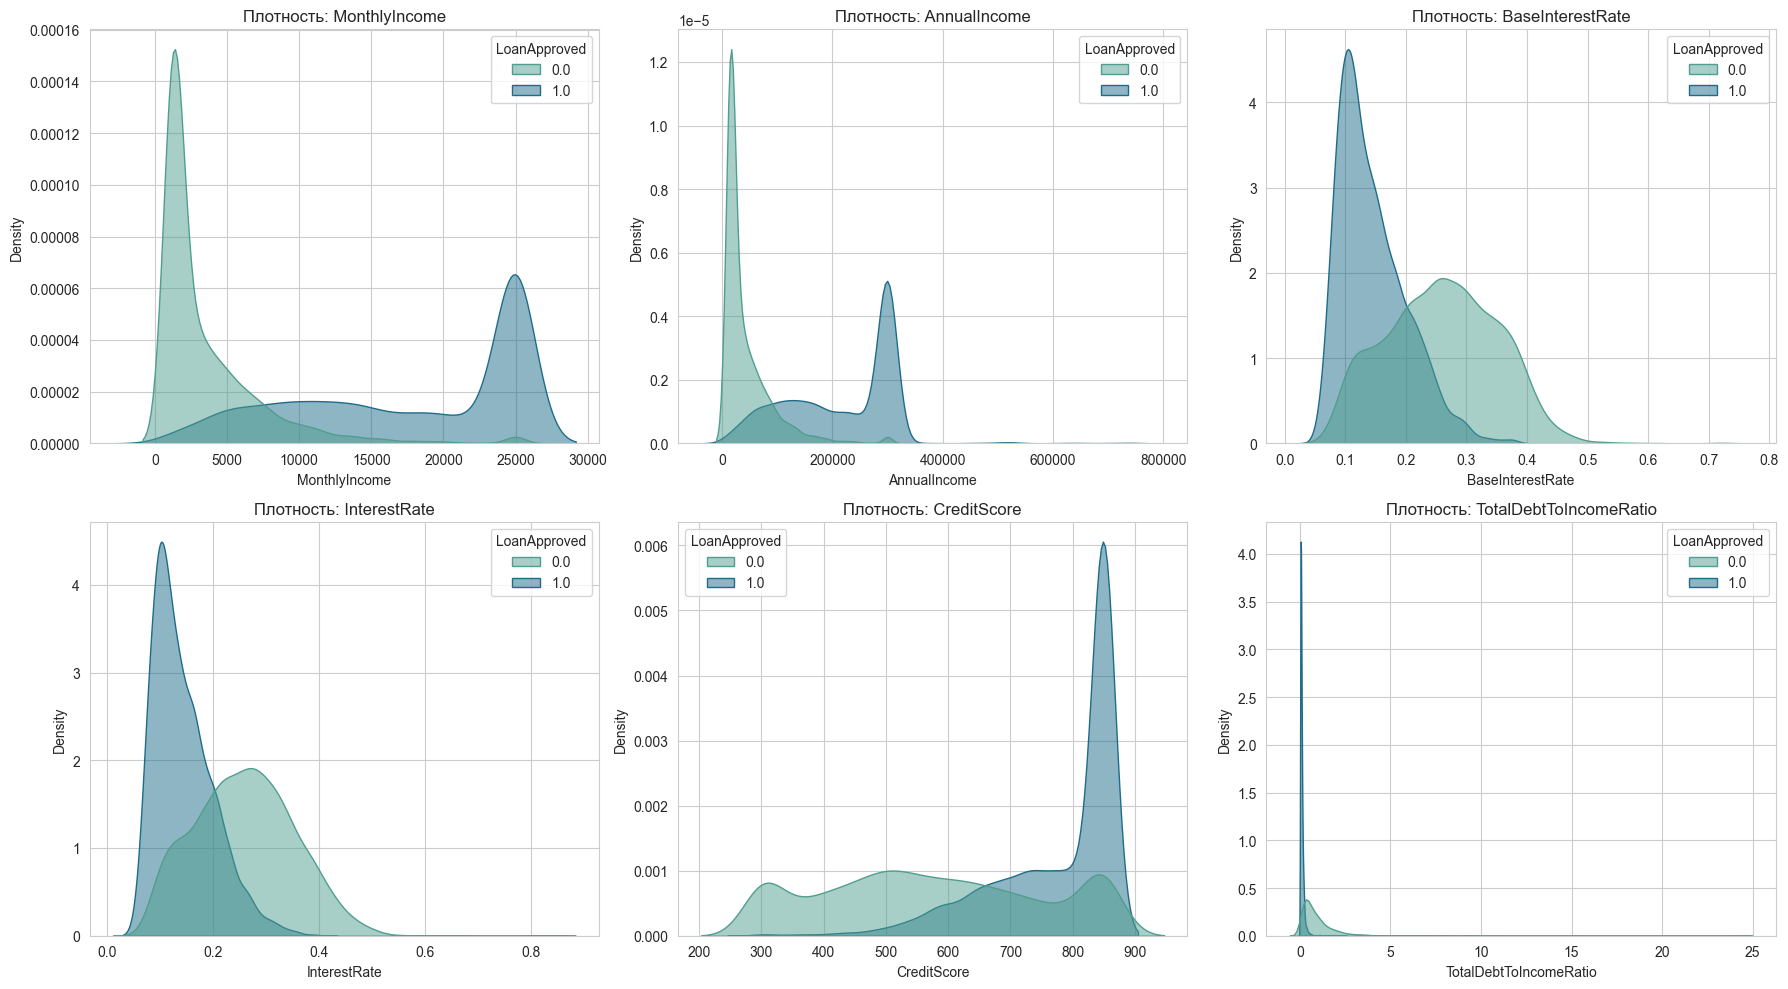

Accuracy match:  True
Precision match: True
Recall match:    True
F1 match:        True
AUC-ROC match:   False
Model                | Time       | AUC       
---------------------------------------------
Custom GBM (Fast)    | 10.26s     | 0.9619
LightGBM             | 0.39s     | 0.9826
XGBoost              | 7.51s     | 0.9811


[I 2025-12-14 16:43:10,122] A new study created in memory with name: no-name-b1f9016d-ad44-4054-b4a8-d89f14c9baf8


CatBoost             | 28.52s     | 0.9817

Победитель: LightGBM (AUC: 0.9826)


[I 2025-12-14 16:43:18,496] Trial 0 finished with value: 0.984700157122905 and parameters: {'n_estimators': 824, 'learning_rate': 0.04253442048992195, 'max_depth': 8, 'num_leaves': 74, 'lambda_l1': 6.758894686515118e-05, 'lambda_l2': 9.34911307395909, 'feature_fraction': 0.6449534696560433, 'bagging_fraction': 0.7639914684788998, 'bagging_freq': 5}. Best is trial 0 with value: 0.984700157122905.
[I 2025-12-14 16:43:22,269] Trial 1 finished with value: 0.9836956531539667 and parameters: {'n_estimators': 432, 'learning_rate': 0.09956061263130032, 'max_depth': 4, 'num_leaves': 77, 'lambda_l1': 0.00019484921389703206, 'lambda_l2': 0.015839685729856296, 'feature_fraction': 0.6652127295279783, 'bagging_fraction': 0.518546738147898, 'bagging_freq': 6}. Best is trial 0 with value: 0.984700157122905.
[I 2025-12-14 16:43:31,421] Trial 2 finished with value: 0.9850740255123103 and parameters: {'n_estimators': 886, 'learning_rate': 0.02925634854375836, 'max_depth': 8, 'num_leaves': 89, 'lambda_l1'


Лучшие параметры: {'n_estimators': 518, 'learning_rate': 0.033017568475730646, 'max_depth': 6, 'num_leaves': 20, 'lambda_l1': 7.770790760326405e-07, 'lambda_l2': 4.839817320631914e-07, 'feature_fraction': 0.7508898394235122, 'bagging_fraction': 0.6949699936748225, 'bagging_freq': 2}
Лучший CV AUC: 0.9854130415956736
submission.csv сохранен.


In [38]:
if __name__ == "__main__":
    

    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    target_col = 'LoanApproved'
    if target_col in train_df.columns:
        train_df = train_df.dropna(subset=[target_col])
    
    perform_detailed_eda(train_df, target_col)
    
    X = train_df.drop(columns=['ID', 'Id', target_col], errors='ignore')
    y = train_df[target_col].astype(int)
    X_test_raw = test_df.drop(columns=['ID', 'Id', target_col], errors='ignore')

    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), 
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ])

    X_processed = preprocessor.fit_transform(X)
    X_test_processed = preprocessor.transform(X_test_raw)
    
    X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)


    dummy = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
    p_pred = dummy.predict(X_val)
    p_prob = dummy.predict_proba(X_val)[:, 1]
    
    print(f"Accuracy match:  {abs(MyMetrics.accuracy(y_val, p_pred) - accuracy_score(y_val, p_pred)) < 1e-9}")
    print(f"Precision match: {abs(MyMetrics.precision(y_val, p_pred) - precision_score(y_val, p_pred)) < 1e-9}")
    print(f"Recall match:    {abs(MyMetrics.recall(y_val, p_pred) - recall_score(y_val, p_pred)) < 1e-9}")
    print(f"F1 match:        {abs(MyMetrics.f1_score(y_val, p_pred) - f1_score(y_val, p_pred)) < 1e-9}")
    print(f"AUC-ROC match:   {abs(MyMetrics.auc_roc(y_val, p_prob) - roc_auc_score(y_val, p_prob)) < 1e-9}")
    
    models = {
        "Custom GBM (Fast)": MyGradientBoostingClassifier(n_estimators=5, max_depth=3),
        "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=42),
        "CatBoost": cb.CatBoostClassifier(n_estimators=100, verbose=0, random_seed=42)
    }
    
    best_model_name = ""
    best_model_auc = 0

    print(f"{'Model':<20} | {'Time':<10} | {'AUC':<10}")
    print("-" * 45)

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_val)[:, 1]
        else:
            y_prob = model.predict(X_val)
            
        score = roc_auc_score(y_val, y_prob)
        elapsed = time.time() - start
        
        print(f"{name:<20} | {elapsed:.2f}s     | {score:.4f}")

        if "Custom" not in name and score > best_model_auc:
            best_model_auc = score
            best_model_name = name

    print(f"\nПобедитель: {best_model_name} (AUC: {best_model_auc:.4f})")
    optuna.logging.set_verbosity(optuna.logging.INFO)

    def objective(trial):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        if "LightGBM" in best_model_name:
            param = {
                'verbosity': -1, 'random_state': 42,
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), 
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            }
            model = lgb.LGBMClassifier(**param)
            
        elif "XGBoost" in best_model_name:
            param = {
                'eval_metric': 'logloss', 'use_label_encoder': False, 'random_state': 42,
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            }
            model = xgb.XGBClassifier(**param)
            
        elif "CatBoost" in best_model_name:
            param = {
                'verbose': 0, 'random_seed': 42,
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'depth': trial.suggest_int('depth', 3, 8),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            }
            model = cb.CatBoostClassifier(**param)
        
        else:
            model = GradientBoostingClassifier(n_estimators=100, random_state=42)

        scores = cross_val_score(model, X_processed, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100) 

    print("\nЛучшие параметры:", study.best_params)
    print("Лучший CV AUC:", study.best_value)

    best_params = study.best_params
    
    if "LightGBM" in best_model_name:
        final_model = lgb.LGBMClassifier(**best_params, random_state=42, verbose=-1)
    elif "XGBoost" in best_model_name:
        final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False, random_state=42)
    elif "CatBoost" in best_model_name:
        final_model = cb.CatBoostClassifier(**best_params, verbose=0, random_seed=42)
    else:
        final_model = GradientBoostingClassifier(**best_params, random_state=42)

    final_model.fit(X_processed, y)
    
    final_preds = final_model.predict(X_test_processed)
    submission = pd.DataFrame({'LoanApproved': final_preds})
    
    submission.to_csv("submission.csv", index_label="ID")
    print("submission.csv сохранен.")